##### 1. 載入套件與資料分割  

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve, auc,
    recall_score, precision_score, fbeta_score
)
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import SMOTE

from category_encoders import TargetEncoder
import statsmodels.api as sm
from scipy.stats import zscore

In [76]:
import os

def save_plot(fig, filename, model_name='logistic_regression'):
    """
    儲存圖表到 ../results/{model_name}/{filename}
    """
    path = f'../results/{model_name}'
    os.makedirs(path, exist_ok=True)
    fig.savefig(f'{path}/{filename}', dpi=300)

##### 2. 讀取資料與切割訓練、驗證與測試集

In [77]:
# 讀取原始資料
df = pd.read_csv('../raw_data/train_2025.csv')

# 分離特徵與標籤
X = df.drop(columns=['claim_number', 'fraud'])
y = df['fraud']

# 切分資料集：60% 訓練、20% 驗證、20% 測試 
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# 建立資料夾
os.makedirs('../processed_data/train', exist_ok=True)
os.makedirs('../processed_data/valid', exist_ok=True)
os.makedirs('../processed_data/test', exist_ok=True)

# 儲存資料到 processed_data 路徑下
X_train.to_csv('../processed_data/train/X_train.csv', index=False)
y_train.to_csv('../processed_data/train/y_train.csv', index=False)

X_valid.to_csv('../processed_data/valid/X_valid.csv', index=False)
y_valid.to_csv('../processed_data/valid/y_valid.csv', index=False)

X_test.to_csv('../processed_data/test/X_test.csv', index=False)
y_test.to_csv('../processed_data/test/y_test.csv', index=False)

##### 3. 資料清洗與預處理

In [78]:
# 在測試集移除 zip_code 開頭為 0 的資料
mask = ~X_train['zip_code'].astype(str).str.startswith('0')
X_train = X_train[mask].reset_index(drop=True)
y_train = y_train[mask].reset_index(drop=True)

# 指定類別與數值欄位
cat_cols = [
    'gender', 'marital_status', 'high_education_ind', 'address_change_ind',
    'living_status', 'zip_code', 'claim_date', 'claim_day_of_week', 'accident_site',
    'witness_present_ind', 'channel', 'policy_report_filed_ind',
    'vehicle_category', 'vehicle_color'
]
num_cols = [col for col in X_train.columns if col not in cat_cols]

# 移除數值欄位離群值（z-score > 3）
z_scores = X_train[num_cols].apply(zscore)
mask_no_outliers = (z_scores.abs() < 3).all(axis=1)
X_train = X_train.loc[mask_no_outliers].reset_index(drop=True)
y_train = y_train.loc[mask_no_outliers].reset_index(drop=True)

##### 4. 建立特徵轉換器（自定義）

In [79]:
def encode_gender(X):
    return (X == 'M').astype(int)

def encode_living_status(X):
    return (X == 'Own').astype(int)

class Zip3Extractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        if hasattr(X, 'columns'):
            self.feature_names_in_ = list(X.columns)
        else:
            self.feature_names_in_ = [f"feature_{i}" for i in range(X.shape[1])]
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names_in_)
        return X.apply(lambda col: col.astype(str).str[:3])


class ExtractMonthYear(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        if hasattr(X, 'columns'):
            self.feature_names_in_ = list(X.columns)
        else:
            self.feature_names_in_ = [f"feature_{i}" for i in range(X.shape[1])]
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names_in_)
        date = pd.to_datetime(X.iloc[:, 0], errors='coerce')
        return date.dt.to_period('M').astype(str).to_frame()

class TargetEncoderWrapper(TargetEncoder):
    def get_feature_names_out(self, input_features=None):
        return input_features if input_features is not None else self.feature_names_in_

class FrequencyEncoderWrapper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        X = pd.Series(X.ravel(), name="feature")
        self.freq_map_ = X.value_counts(normalize=True).to_dict()
        return self
    def transform(self, X):
        X = pd.Series(X.ravel(), name="feature")
        return X.map(self.freq_map_).fillna(0).values.reshape(-1, 1)


##### 5. 建立欄位轉換流程與預處理器

In [80]:
# ===== Pipeline 建構 =====

# 僅補值（所有變數只有這兩欄有缺值，不過比例很低）
marital_witness_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))])

# 對'gender'做lable encoding
gender_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('label_encoder', FunctionTransformer(encode_gender, validate=False, feature_names_out='one-to-one'))])

# 對'living_status'做lable encoding
living_status_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('label_encoder', FunctionTransformer(encode_living_status, validate=False, feature_names_out='one-to-one'))])

# 對'zip_code'做取前三值、onehot encoding
zip3_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('zip3_extract', Zip3Extractor()), 
    ('target', TargetEncoderWrapper())])

# 對'claim_date'取年月、target encoding
claim_date_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('extract_month_year', ExtractMonthYear()), 
    ('target', TargetEncoderWrapper())])

# 對數值行欄位做標準化
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', MinMaxScaler())])

# 對剩下要處理的欄位做target encoding
target_cat_cols = ['claim_day_of_week', 'accident_site', 'channel', 'vehicle_category', 'vehicle_color']
target_cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target', TargetEncoderWrapper())])

# ===  整合所有欄位轉換 ===
transformers = [
    ('marital_witness', marital_witness_pipeline, ['marital_status', 'witness_present_ind']),
    ('gender', gender_pipeline, ['gender']),
    ('living_status', living_status_pipeline, ['living_status']),
    ('zip_code', zip3_pipeline, ['zip_code']),
    ('claim_date', claim_date_pipeline, ['claim_date']),
    ('num', num_pipeline, num_cols),
    ('cat_imputer', target_cat_pipeline, target_cat_cols)
]

# 建立欄位轉換器，之後的特徵工程都依賴preprocessor
preprocessor = ColumnTransformer(transformers, remainder='passthrough')

##### 6. 特徵轉換 + SMOTENC 處理不平衡

In [81]:
# 對訓練與驗證集做轉換並建立欄位名稱
X_train_final_array = preprocessor.fit_transform(X_train, y_train)
X_valid_final_array = preprocessor.transform(X_valid)

# 儲存所有欄位（包括未處理的）
try:
    feature_names = preprocessor.get_feature_names_out()
except Exception:
    feature_names = [f"feature_{i}" for i in range(X_train_final_array.shape[1])]

X_train = pd.DataFrame(X_train_final_array, columns=feature_names, index=X_train.index)
X_valid_final = pd.DataFrame(X_valid_final_array, columns=feature_names, index=X_valid.index)

# 使用 SMOTENC 對不平衡資料做過採樣處理（判斷哪些欄位是類別欄位）
categorical_feature_indices = [
    i for i, col in enumerate(X_train.columns)
    if col.startswith('gender__') or col.startswith('living_status__')
    or col.startswith('zip_code__') or col.startswith('claim_date__')
    or col.startswith('cat_imputer__') or col.startswith('remainder__')
]

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
# smote_nc = SMOTENC(categorical_features=categorical_feature_indices, random_state=42)
# X_resampled, y_resampled = smote_nc.fit_resample(X_train, y_train)

##### 7. 邏輯斯迴歸（統計模型 & sklearn 模型）

In [82]:
X_with_const = sm.add_constant(X_resampled)
logit_model = sm.Logit(y_resampled, X_with_const).fit()
print(logit_model.summary())

# 使用 sklearn 的 LogisticRegression 訓練模型，做為實際預測用
clf = LogisticRegression(max_iter=100, solver='liblinear')
clf.fit(X_resampled, y_resampled)

Optimization terminated successfully.
         Current function value: 0.614688
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  fraud   No. Observations:                16476
Model:                          Logit   Df Residuals:                    16452
Method:                           MLE   Df Model:                           23
Date:                Sat, 21 Jun 2025   Pseudo R-squ.:                  0.1132
Time:                        04:12:34   Log-Likelihood:                -10128.
converged:                       True   LL-Null:                       -11420.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -15.6700      1.962     -7.989      0.000     -19.514     -11.825
feature_0     -0.4856      0.

LogisticRegression(solver='liblinear')

##### 8. 測試集預測與績效評估（預設閾值 0.5）


In [83]:
X_test_final = preprocessor.transform(X_test)
y_pred_test = clf.predict(X_test_final)

print("閾值0.5的測試集績效報告：")
print(classification_report(y_test, y_pred_test))

cm = confusion_matrix(y_test, y_pred_test)
print("閾值0.5的測試集混淆矩陣：")
print("       Pred 0    Pred 1")
print(f"True 0   {cm[0,0]:>5}      {cm[0,1]:>5}")
print(f"True 1   {cm[1,0]:>5}      {cm[1,1]:>5}")

閾值0.5的測試集績效報告：
              precision    recall  f1-score   support

           0       0.90      0.63      0.74      3031
           1       0.25      0.63      0.35       569

    accuracy                           0.63      3600
   macro avg       0.57      0.63      0.55      3600
weighted avg       0.80      0.63      0.68      3600

閾值0.5的測試集混淆矩陣：
       Pred 0    Pred 1
True 0    1919       1112
True 1     208        361


##### 9. 驗證集選擇最佳閾值（Recall ≥ 0.8 下最大 Precision）

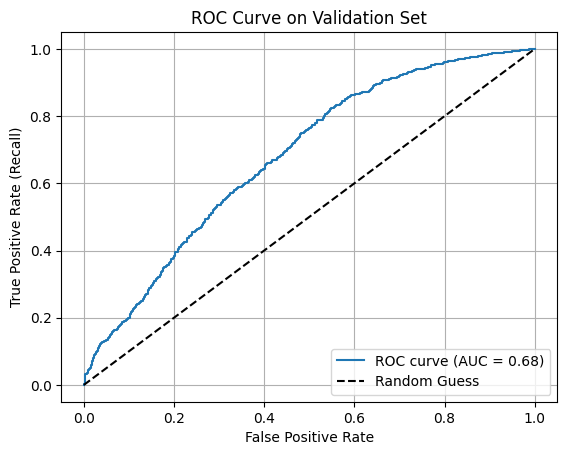

最佳閾值（使 recall ≥ 0.8 時 precision 最大）：0.4164


In [84]:
# 1. 計算預測機率（類別為 1）
y_valid_proba = clf.predict_proba(X_valid_final)[:, 1]

# 2. 計算 ROC 曲線與 AUC 值
fpr, tpr, thresholds = roc_curve(y_valid, y_valid_proba)
roc_auc = auc(fpr, tpr)

# 3. 畫出驗證集的 ROC 曲線
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve on Validation Set')
plt.legend(loc='lower right')
plt.grid()
save_plot(plt.gcf(), 'roc_curve_valid.png', model_name='logistic_regression')
plt.show()

# 4. 以 recall 下限 = 0.8，尋找最佳 precision 對應的閾值
target_recall = 0.8
best_threshold = 0
best_prec = 0

for threshold in thresholds:
    y_pred_thresh = (y_valid_proba >= threshold).astype(int)
    recall = recall_score(y_valid, y_pred_thresh)
    precision = precision_score(y_valid, y_pred_thresh)
    if recall >= target_recall and precision > best_prec:
        best_prec = precision
        best_threshold = threshold

print(f'最佳閾值（使 recall ≥ 0.8 時 precision 最大）：{best_threshold:.4f}')

##### 10. 測試集應用最佳閾值


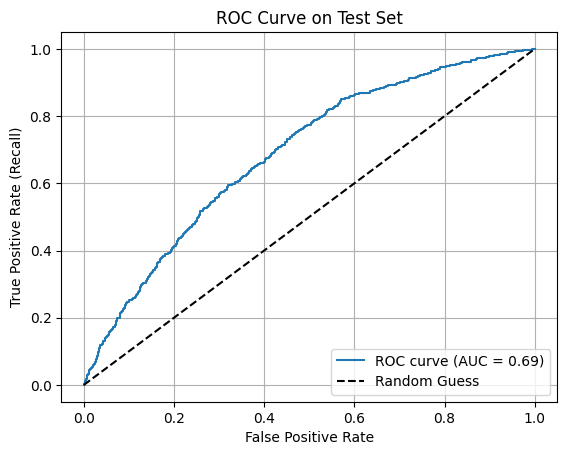

最佳閾值的測試集績效報告：
              precision    recall  f1-score   support

           0       0.93      0.47      0.63      3031
           1       0.22      0.80      0.35       569

    accuracy                           0.53      3600
   macro avg       0.57      0.64      0.49      3600
weighted avg       0.81      0.53      0.58      3600

AUC: 0.6875
F2-score: 0.5251
最佳閾值的測試集混淆矩陣：
       Pred 0    Pred 1
True 0    1438       1593
True 1     115        454


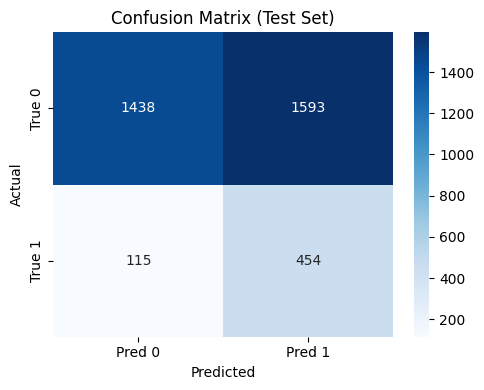

In [ ]:
# 1. 測試集預測機率（類別為 1）
y_test_proba = clf.predict_proba(X_test_final)[:, 1]

# 2. 計算 ROC 曲線與 AUC 值
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

# 3. 畫出測試集 ROC 曲線
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve on Test Set')
plt.legend(loc='lower right')
plt.grid()
save_plot(plt.gcf(), 'roc_curve_test.png', model_name='logistic_regression')
plt.show()

# 4. 使用驗證集上選出的最佳閾值做預測
y_test_pred = (y_test_proba >= best_threshold).astype(int)

# 5. 顯示最佳閾值下的測試集績效評估報告
print("最佳閾值的測試集績效報告：")
print(classification_report(y_test, y_test_pred))
print(f'AUC: {roc_auc:.04f}')
print(f'F2-score: {fbeta_score(y_test, y_test_pred, beta=2):.04f}')

cm = confusion_matrix(y_test, y_test_pred)
print("最佳閾值的測試集混淆矩陣：")
print("       Pred 0    Pred 1")
print(f"True 0   {cm[0,0]:>5}      {cm[0,1]:>5}")
print(f"True 1   {cm[1,0]:>5}      {cm[1,1]:>5}")

# 🔲 混淆矩陣圖儲存
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0', 'Pred 1'],
            yticklabels=['True 0', 'True 1'])
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
save_plot(plt.gcf(), 'confusion_matrix.png', model_name='logistic_regression')
plt.show()